In [1]:
import condo
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
import warnings

from matplotlib.colors import LogNorm

In [2]:
N_T = 200
N_S = 100

# How confounder X affects the distribution of T and S
theta_m = 4
theta_b = 1
phi_m = 1
phi_b = 1

# How batch effect affects S
batch_m = 2
batch_b = 5
# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

In [3]:
""" normal distribution
X_T = np.random.normal(4, 1, size=(N_T,))
X_S = np.random.normal(5, 1, size=(N_S,))
"""
X_T = np.sort(np.random.uniform(1, 8, size=(N_T,1)))
X_S = np.sort(np.random.uniform(4, 8, size=(N_S,1)))

In [4]:
mu_T = theta_m * X_T + theta_b
sigma_T = phi_m * X_T + phi_b
mu_S = theta_m * X_S + theta_b
sigma_S = phi_m * X_S + phi_b
""" Confounder with nonlinear effect
mu_T = theta_m * np.maximum(X_T-5, 0) + theta_b
sigma_T = phi_m * np.maximum(X_T-5, 0) + phi_b
mu_S = theta_m * np.maximum(X_S-5, 0) + theta_b
sigma_S = phi_m * np.maximum(X_S-5, 0) + phi_b
"""

T = np.random.normal(mu_T, sigma_T)
Strue = np.random.normal(mu_S, sigma_S)
Sbatch = batch_m * Strue + batch_b

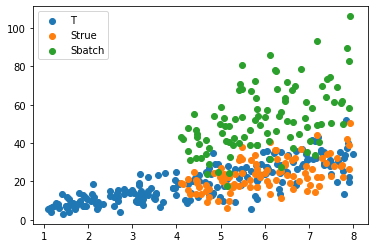

In [5]:
plt.figure()
plt.scatter(X_T, T)
plt.scatter(X_S, Strue)
plt.scatter(X_S, Sbatch)
plt.legend(['T', 'Strue', 'Sbatch']);

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        joint=False,
        kld_direction="reverse",
        heteroscedastic=True,
        debug=True,
        verbose=1
    )
    cder.fit(Sbatch, T, X_S, X_T)
    Sadapted = cder.transform(Sbatch)

Optimization terminated successfully.
         Current function value: -324.990784
         Iterations: 18
         Function evaluations: 22


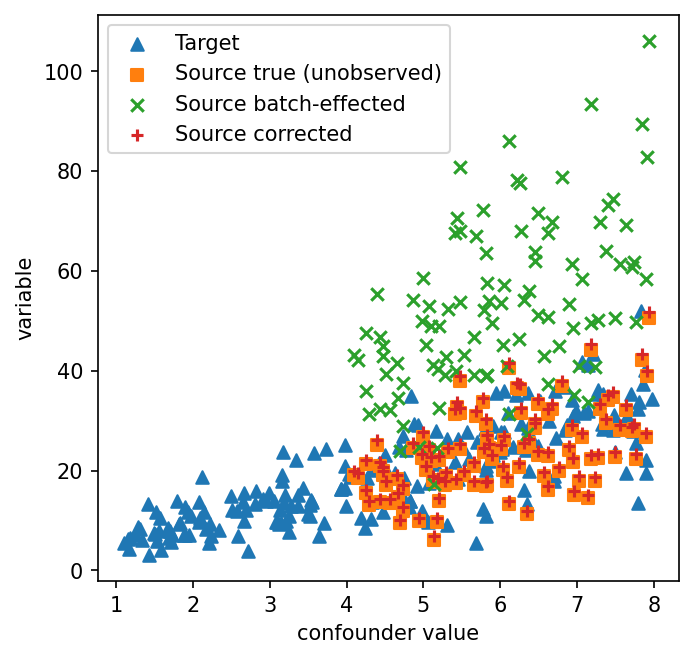

In [7]:
plt.figure(figsize=(5,5), dpi=150)
plt.scatter(X_T, T, marker='^')
plt.scatter(X_S, Strue, marker='s')
plt.scatter(X_S, Sbatch, marker='x')
plt.scatter(X_S, Sadapted, marker='+')
legend = [
    'Target',
    'Source true (unobserved)',
    'Source batch-effected',
    'Source corrected',
]
plt.legend(legend);
plt.xlabel('confounder value');
plt.ylabel('variable');

In [8]:
print(cder.m_, cder.b_)
print(batch_m, batch_b)
print(true_m, true_b)

[0.50575781] [-1.93000007]
2 5
0.5 -2.5


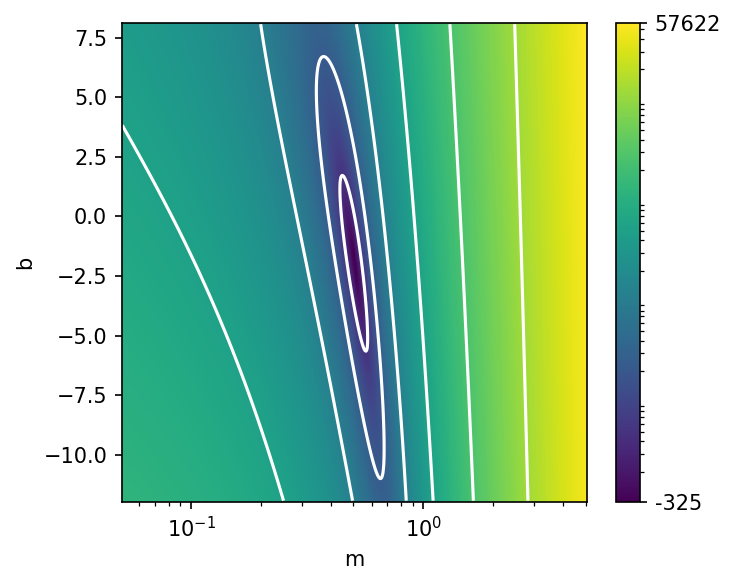

In [9]:
plt.figure(figsize=(5,4), dpi=150)
color_vals = cder.mb_objs_ + 1 - np.min(cder.mb_objs_)
plt.pcolormesh(
    cder.m_plot_, cder.b_plot_, color_vals.T,
    norm=LogNorm(vmin=color_vals.min(), vmax=color_vals.max()));
plt.xscale('log');
cbar = plt.colorbar();
cbar.ax.get_yaxis().set_ticks([color_vals.min(), color_vals.max()]);
cbar.ax.get_yaxis().set_ticklabels(
    [int(np.round(cder.mb_objs_.min())), int(np.round(cder.mb_objs_.max()))]);
cont = plt.contour(
    cder.m_plot_, cder.b_plot_, color_vals.T, 
    levels=np.geomspace(color_vals.min(), color_vals.max(), 8), colors='white', linestyles='solid');
plt.ylabel('b');
plt.xlabel('m');
plt.tight_layout();

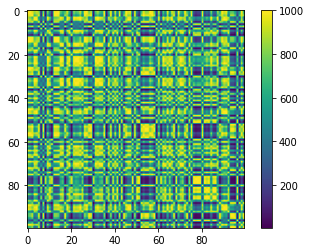

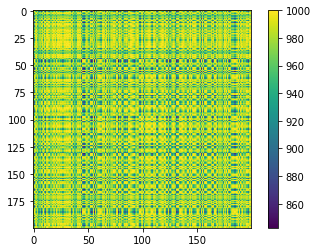

In [10]:
plt.figure();
plt.imshow(cder.gpS_.kernel_(cder.gpS_.X_train_, cder.gpS_.X_train_))
plt.colorbar();
plt.figure();
plt.imshow(cder.gpT_.kernel_(cder.gpT_.X_train_, cder.gpT_.X_train_));
plt.colorbar();

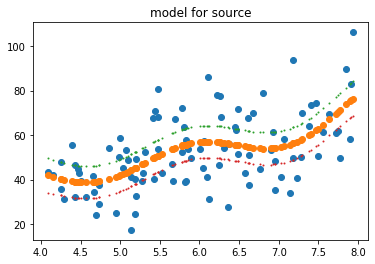

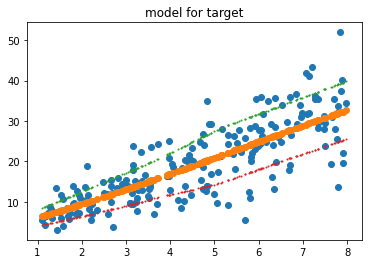

In [14]:
plt.figure()
plt.scatter(cder.gpS_.X_train_, cder.gpS_.y_train_);
pred_mu, pred_sigma = cder.gpS_.predict(cder.gpS_.X_train_, return_std=True);
plt.scatter(cder.gpS_.X_train_, pred_mu);
plt.scatter(cder.gpS_.X_train_, pred_mu+pred_sigma, s=1);
plt.scatter(cder.gpS_.X_train_, pred_mu-pred_sigma, s=1);
plt.title('model for source');

plt.figure()
plt.scatter(cder.gpT_.X_train_, cder.gpT_.y_train_);
pred_mu, pred_sigma = cder.gpT_.predict(cder.gpT_.X_train_, return_std=True);
plt.scatter(cder.gpT_.X_train_, pred_mu);
plt.scatter(cder.gpT_.X_train_, pred_mu+pred_sigma, s=1);
plt.scatter(cder.gpT_.X_train_, pred_mu-pred_sigma, s=1);
plt.title('model for target');